<a href="https://colab.research.google.com/github/jamelof23/ASL/blob/main/InterFaceGAN-Jam4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch Codebase and Models

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1 -O models/pretrain/pggan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1 -O models/pretrain/stylegan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 613 (delta 94), reused 92 (delta 92), pack-reused 489 (from 1)
Receiving objects: 100% (613/613), 13.72 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (204/204), done.


# Define Utility Functions

In [ ]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

# A dictionary containing information about the models available (e.g., pggan, stylegan).
from models.model_settings import MODEL_POOL

from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'pggan':
    generator = PGGANGenerator(model_name)
  elif gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  #Setting a random seed ensures reproducibility. Every time the function is called with the same seed, it generates the same latent codes are typically sampled from a standard normal distribution.
  np.random.seed(seed)
  #The function uses generator.easy_sample(num) to sample num latent vectors from the Z space.
  codes = generator.easy_sample(num)
  print(f"[INFO] Latent codes in Z space (before mapping):")
  print(f"Shape: {codes.shape}")
  print(f"Sample data: {codes[0, :5]}")  # Print first 5 elements of the first vector
  #This condition checks if the generator is using StyleGAN and whether we want to use the W space.
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    #he codes sampled in Z space are first converted to a PyTorch tensor and moved to the device (CPU or GPU):
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    # Print information before mapping
    print(f"[INFO] Latent codes as tensor (before mapping to W space):")
    print(f"Shape: {codes.shape}")
    print(f"Sample data: {codes[0, :5]}") #extracts the first 5 elements of the first latent vector.
    #The codes are then passed through the StyleGAN's mapping network to convert them into the W space:
    codes = generator.get_value(generator.model.mapping(codes))
    # Print information after mapping to W space
    print(f"[INFO] Latent codes in W space (after mapping):")
    print(f"Shape: {codes.shape}")
    print(f"Sample data: {codes[0, :5]}") #extracts the first 5 elements of the first latent vector.
  #Finally, the function returns the latent codes, which can either be in the Z space or transformed to the W space, depending on the inputs.
  #The mapping network transforms Z vectors into the W space, which is disentangled.
  return codes


#main function display a grid of images

#images: A NumPy array containing multiple images. The expected shape is (num, height, width, channels), where:
#col: The number of columns to display in the grid.
#viz_size: The size (in pixels) to which each image will be resized before displaying (default is 256).
def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  # Extracting the Shape of the Images
  num, height, width, channels = images.shape
  #Ensures that the number of images (num) is divisible by the number of columns (col).
  #This makes sure that the images can be arranged into a complete grid without leaving any empty cells.
  assert num % col == 0
  #Computes the number of rows needed to fit all the images in the grid.
  row = num // col

  #Creates an empty canvas (a blank image) to hold all the images in a grid format.
  #The canvas has dimensions (viz_size * row, viz_size * col, channels), where:
  #viz_size * row: Total height of the grid.
  #viz_size * col: Total width of the grid.
  #channels: Number of color channels (same as the input images).
  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  #Placing Each Image on the Canvas
  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    #Resizing and Copying Each Image to the Canvas
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  #Converting the Canvas to a Displayable Format
  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  #Displaying the Image Using IPython
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [ ]:
#This line is a special Jupyter Notebook cell annotation, display-mode: "form": Displays the code as a collapsible form in the notebook,
#run: "auto": Automatically runs the cell whenever you change any of the parameters in the form.
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "W" #@param ['Z', 'W']

#The function build_generator(model_name) is defined elsewhere and is responsible for loading the appropriate model based on the model_name parameter.
generator = build_generator(model_name)

# A list of attributes that you want to manipulate in the generated images.
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
#boundaries: An empty dictionary that will store the attribute boundaries for each of the attributes in ATTRS
boundaries = {}

#Loading Attribute Boundaries
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  #np.load() loads the boundary vectors from .npy files, which contain pre-computed directions in the latent space that control the attributes.
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

/content/interfacegan/models/stylegan_generator.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.model_path)


**MY CODDE** # Sample latent codes

[INFO] Latent codes in W space shape: (1, 512)


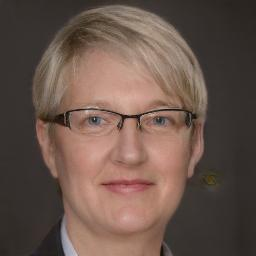

In [ ]:
import torch

# Convert latent_codes from numpy array to torch tensor
latent_codes_tensor = torch.from_numpy(latent_codes).float().to(generator.run_device)

# Map the latent code from Z to W space
with torch.no_grad():
    w_codes_tensor = generator.model.mapping(latent_codes_tensor)
    w_codes = generator.get_value(w_codes_tensor)

# Use W space for StyleGAN synthesis
latent_codes = w_codes  # Now latent_codes is in W space with shape (1, 512)
print(f"[INFO] Latent codes in W space shape: {latent_codes.shape}")
synthesis_kwargs = {'latent_space_type': 'W'}

# Generate the image using your custom latent vector in W space
images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']

# Display the generated image
imshow(images, col=1)



# Sample latent codes

[INFO] Latent codes in Z space (before mapping):
Shape: (1, 512)
Sample data: [1.7653587  0.4004535  0.97946274 2.2425525  1.868941  ]
[INFO] Latent codes as tensor (before mapping to W space):
Shape: torch.Size([1, 512])
Sample data: tensor([1.7654, 0.4005, 0.9795, 2.2426, 1.8689], device='cuda:0')
[INFO] Latent codes in W space (after mapping):
Shape: (1, 512)
Sample data: [ 0.21155858 -0.15949039 -0.17410852 -0.15041943 -0.18774043]


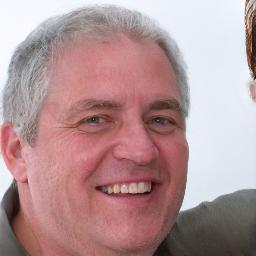

In [ ]:
#@title { display-mode: "form", run: "auto" }

num_samples = 1 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 0 #@param {type:"slider", min:0, max:1000, step:1}

#sample_codes(): This function samples latent vectors based on the num_samples and noise_seed parameters.
#The latent_space_type parameter specifies whether to sample in the Z space or the W space.
#The result, latent_codes, is a batch of latent vectors that will be used to generate images.
latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
# checks the type of generator being used.
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  #If the generator is StyleGAN and the W space is selected, it sets synthesis_kwargs to include 'latent_space_type': 'W'.
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  #For other cases (like Z space or PGGAN), no additional arguments are needed, so synthesis_kwargs remains an empty dictionary.
  synthesis_kwargs = {}

#synthesis_kwargs is a dictionary that contains optional arguments for the image synthesis function (easy_synthesize).
#If the generator type is 'stylegan' and you have chosen to use the W space, then
#synthesis_kwargs is set to {'latent_space_type': 'W'}.
#This tells the easy_synthesize method to use the W space for generating images.

#The **synthesis_kwargs unpacks the dictionary and passes its contents as keyword arguments({'latent_space_type': 'W'}) to the easy_synthesize() function.
# 'latent_space_type': 'W' passed This ensures that the generator uses the W space for synthesis.
# use synthesis_kwargs when You are using StyleGAN and want to generate images in the W space, which provides more control and disentangled features.
# Exclude when You are using StyleGAN with the Z space.
images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

**My Code** Edit facial attributes

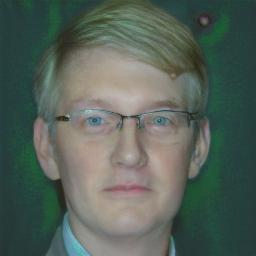

In [ ]:
import numpy as np

# Differential Privacy Parameters (Slider Values)
epsilon = 2.04  # @param {"type":"slider","min":0.01,"max":5,"step":0.01}
delta = 1e-7  # @param {type:"slider", min:1e-7, max:1e-3, step:1e-7}
clipping_threshold = 0.8  # @param {type:"slider", min:0.1, max:5.0, step:0.1}

# Dropdown Menu for Attribute Selection
attribute_selection = "Age"  # @param ["Age", "Gender", "Both"]

# Sliders for the Selected Attributes
if attribute_selection in ["Age", "Both"]:
    age = 3  # @param {type:"slider", min:0.0, max:3.0, step:0.1}
else:
    age = 0  # Disable age if not selected

if attribute_selection in ["Gender", "Both"]:
    gender = 1  # @param {type:"slider", min:0.0, max:3.0, step:0.1}
else:
    gender = 0  # Disable gender if not selected

# Function to add Gaussian noise for differential privacy
def add_gaussian_noise(epsilon, delta, boundary):
    """
    Adds Gaussian noise to a vector for differential privacy.

    Args:
        epsilon (float): Privacy budget.
        delta (float): Probability of failure.
        boundary (np.ndarray): Attribute boundary vector.

    Returns:
        np.ndarray: Noise scaled by boundary.
    """
    # Compute the standard deviation for Gaussian noise
    sigma = np.sqrt(2 * np.log(1.25 / delta)) / epsilon

    # Generate Gaussian noise
    noise = np.random.normal(0, sigma, boundary.shape)

    # Return the noise scaled by the boundary
    return boundary * noise

# Copy the original latent codes
new_codes = latent_codes.copy()

# Add noise only to the selected attributes
for attr_name in ["age", "gender"]:  # Only iterate over selected attributes
    attr_value = eval(attr_name)  # Get the slider value for the current attribute

    # Skip attributes with a slider value of 0
    if attr_value == 0:
        continue

    # Add Gaussian noise to the boundary
    noised_boundary = add_gaussian_noise(
        epsilon=epsilon,
        delta=delta,
        boundary=boundaries[attr_name]
    )

    # Add the noise-modified boundary to the latent codes
    new_codes += noised_boundary * attr_value

# Apply clipping as the final step
new_codes = np.clip(new_codes, -clipping_threshold, clipping_threshold)

# Generate and display the new images
new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)


# Edit facial attributes

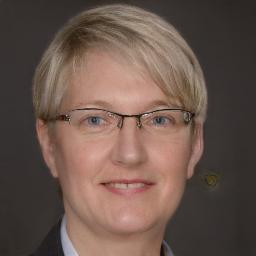

In [ ]:
#@title { display-mode: "form", run: "auto" }

age = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = -0.2 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Copying the Original Latent Codes
new_codes = latent_codes.copy()

#The loop iterates over the list of attributes (ATTRS), which is defined earlier in  code:
# boundaries[attr_name]: pre-computed direction vector in the latent space
#eval(attr_name): This converts the name of the attribute (e.g., 'age', 'smile') into its current value from the sliders.
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)

All

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1 -O models/pretrain/pggan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1 -O models/pretrain/stylegan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

# A dictionary containing information about the models available (e.g., pggan, stylegan).
from models.model_settings import MODEL_POOL

from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'pggan':
    generator = PGGANGenerator(model_name)
  elif gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  #Setting a random seed ensures reproducibility. Every time the function is called with the same seed, it generates the same latent codes are typically sampled from a standard normal distribution.
  np.random.seed(seed)
  #The function uses generator.easy_sample(num) to sample num latent vectors from the Z space.
  codes = generator.easy_sample(num)
  print(f"[INFO] Latent codes in Z space (before mapping):")
  print(f"Shape: {codes.shape}")
  print(f"Sample data: {codes[0, :5]}")  # Print first 5 elements of the first vector
  #This condition checks if the generator is using StyleGAN and whether we want to use the W space.
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    #he codes sampled in Z space are first converted to a PyTorch tensor and moved to the device (CPU or GPU):
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    # Print information before mapping
    print(f"[INFO] Latent codes as tensor (before mapping to W space):")
    print(f"Shape: {codes.shape}")
    print(f"Sample data: {codes[0, :5]}") #extracts the first 5 elements of the first latent vector.
    #The codes are then passed through the StyleGAN's mapping network to convert them into the W space:
    codes = generator.get_value(generator.model.mapping(codes))
    # Print information after mapping to W space
    print(f"[INFO] Latent codes in W space (after mapping):")
    print(f"Shape: {codes.shape}")
    print(f"Sample data: {codes[0, :5]}") #extracts the first 5 elements of the first latent vector.
  #Finally, the function returns the latent codes, which can either be in the Z space or transformed to the W space, depending on the inputs.
  #The mapping network transforms Z vectors into the W space, which is disentangled.
  return codes


#main function display a grid of images

#images: A NumPy array containing multiple images. The expected shape is (num, height, width, channels), where:
#col: The number of columns to display in the grid.
#viz_size: The size (in pixels) to which each image will be resized before displaying (default is 256).
def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  # Extracting the Shape of the Images
  num, height, width, channels = images.shape
  #Ensures that the number of images (num) is divisible by the number of columns (col).
  #This makes sure that the images can be arranged into a complete grid without leaving any empty cells.
  assert num % col == 0
  #Computes the number of rows needed to fit all the images in the grid.
  row = num // col

  #Creates an empty canvas (a blank image) to hold all the images in a grid format.
  #The canvas has dimensions (viz_size * row, viz_size * col, channels), where:
  #viz_size * row: Total height of the grid.
  #viz_size * col: Total width of the grid.
  #channels: Number of color channels (same as the input images).
  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  #Placing Each Image on the Canvas
  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    #Resizing and Copying Each Image to the Canvas
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  #Converting the Canvas to a Displayable Format
  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  #Displaying the Image Using IPython
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

#This line is a special Jupyter Notebook cell annotation, display-mode: "form": Displays the code as a collapsible form in the notebook,
#run: "auto": Automatically runs the cell whenever you change any of the parameters in the form.
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "W" #@param ['Z', 'W']

#The function build_generator(model_name) is defined elsewhere and is responsible for loading the appropriate model based on the model_name parameter.
generator = build_generator(model_name)

# A list of attributes that you want to manipulate in the generated images.
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
#boundaries: An empty dictionary that will store the attribute boundaries for each of the attributes in ATTRS
boundaries = {}

#Loading Attribute Boundaries
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  #np.load() loads the boundary vectors from .npy files, which contain pre-computed directions in the latent space that control the attributes.
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

    #@title { display-mode: "form", run: "auto" }

num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 319 #@param {type:"slider", min:0, max:1000, step:1}

#sample_codes(): This function samples latent vectors based on the num_samples and noise_seed parameters.
#The latent_space_type parameter specifies whether to sample in the Z space or the W space.
#The result, latent_codes, is a batch of latent vectors that will be used to generate images.
latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
# checks the type of generator being used.
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  #If the generator is StyleGAN and the W space is selected, it sets synthesis_kwargs to include 'latent_space_type': 'W'.
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  #For other cases (like Z space or PGGAN), no additional arguments are needed, so synthesis_kwargs remains an empty dictionary.
  synthesis_kwargs = {}

#synthesis_kwargs is a dictionary that contains optional arguments for the image synthesis function (easy_synthesize).
#If the generator type is 'stylegan' and you have chosen to use the W space, then
#synthesis_kwargs is set to {'latent_space_type': 'W'}.
#This tells the easy_synthesize method to use the W space for generating images.

#The **synthesis_kwargs unpacks the dictionary and passes its contents as keyword arguments({'latent_space_type': 'W'}) to the easy_synthesize() function.
# 'latent_space_type': 'W' passed This ensures that the generator uses the W space for synthesis.
# use synthesis_kwargs when You are using StyleGAN and want to generate images in the W space, which provides more control and disentangled features.
# Exclude when You are using StyleGAN with the Z space.
images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

#@title { display-mode: "form", run: "auto" }

age = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = 0 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Copying the Original Latent Codes
new_codes = latent_codes.copy()

#The loop iterates over the list of attributes (ATTRS), which is defined earlier in  code:
# boundaries[attr_name]: pre-computed direction vector in the latent space
#eval(attr_name): This converts the name of the attribute (e.g., 'age', 'smile') into its current value from the sliders.
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)
